<a href="https://colab.research.google.com/github/ekkune/projects/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib



In [7]:
data = sns.load_dataset('titanic')


data['family_size'] = data['sibsp'] + data['parch'] + 1

data['is_alone'] = (data['family_size'] == 1).astype(int)

data['sibsp_bin'] = pd.cut(data['sibsp'], bins=[-1, 0, 2, 10], labels=[0, 1, 2])
data['parch_bin'] = pd.cut(data['parch'], bins=[-1, 0, 2, 10], labels=[0, 1, 2])


data['age'].fillna(data['age'].median(), inplace=True)
data['fare'].fillna(data['fare'].median(), inplace=True)
data['age_bin'] = pd.cut(data['age'], bins=[0, 12, 18, 30, 50, 100], labels=[0, 1, 2, 3, 4])
data['fare_log'] = np.log1p(data['fare'])


data['sex'] = data['sex'].map({'male': 0, 'female': 1})
data['embarked'] = data['embarked'].fillna(data['embarked'].mode()[0])
data['embarked'] = data['embarked'].map({'S': 0, 'C': 1, 'Q': 2})


data['sibsp_bin'] = data['sibsp_bin'].cat.codes
data['parch_bin'] = data['parch_bin'].cat.codes
data['age_bin'] = data['age_bin'].cat.codes


features = ['pclass', 'sex', 'age', 'fare_log', 'family_size', 'is_alone', 'sibsp_bin', 'parch_bin', 'age_bin', 'embarked']
X = data[features]
y = data['survived']

if X.isnull().any().any() or y.isnull().any():
    raise ValueError("Обнаружены NaN в данных!")
if np.isinf(X).any().any():
    raise ValueError("Обнаружены бесконечные значения в данных!")

scaler = StandardScaler()
X[['age', 'fare_log', 'family_size']] = scaler.fit_transform(X[['age', 'fare_log', 'family_size']])



/tmp/ipython-input-7-2966397619.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['age'].fillna(data['age'].median(), inplace=True)
/tmp/ipython-input-7-2966397619.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [8]:
# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [9]:
# Определяем модели и параметры для GridSearchCV
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [5, 10, None], 'min_samples_split': [2, 5]}
param_grid_xgb = {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1]}

# GridSearchCV для Random Forest
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)

# GridSearchCV для XGBoost
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='accuracy')
grid_xgb.fit(X_train, y_train)

# Ансамбль
ensemble = VotingClassifier(estimators=[
    ('rf', grid_rf.best_estimator_),
    ('xgb', grid_xgb.best_estimator_)
], voting='soft')
ensemble.fit(X_train, y_train)

# Словарь для результатов
models = {'Random Forest': grid_rf.best_estimator_, 'XGBoost': grid_xgb.best_estimator_, 'Ensemble': ensemble}
results = {}

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:49:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:49:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:49:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:49:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:49:22] WARNING: /w


Модель: Random Forest
Лучшие параметры: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
Точность: 0.82
Кросс-валидация: 0.82 (+/- 0.05)
Отчет классификации:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       105
           1       0.83      0.70      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.81       179



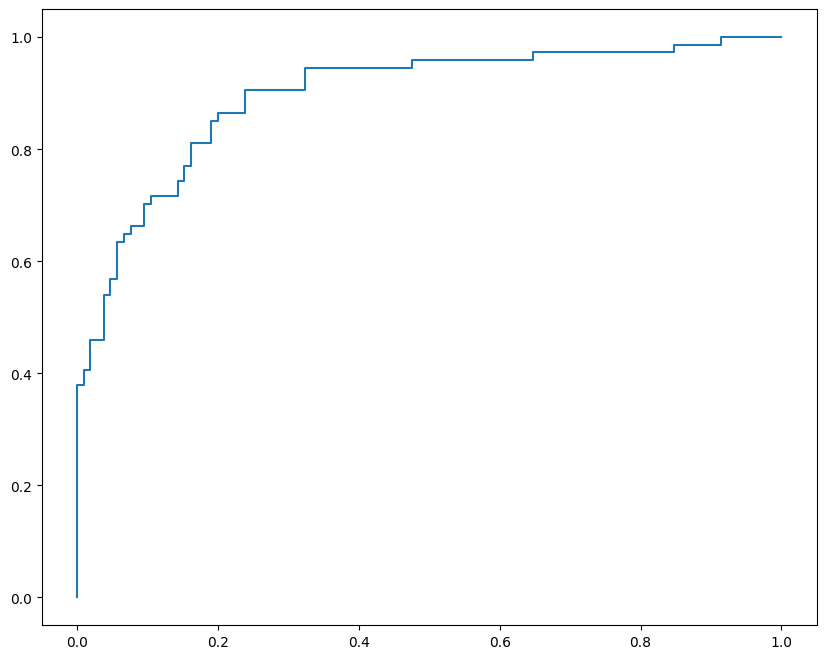

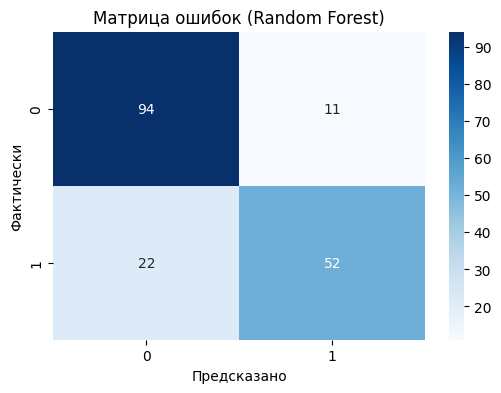

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:49:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:49:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:49:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:49:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:49:39] WARNING: /w


Модель: XGBoost
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Точность: 0.81
Кросс-валидация: 0.83 (+/- 0.04)
Отчет классификации:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       105
           1       0.82      0.69      0.75        74

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



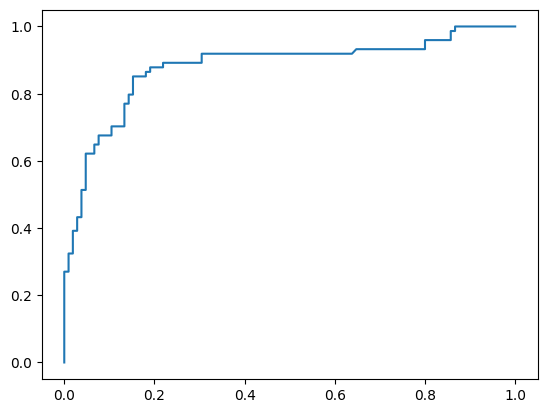

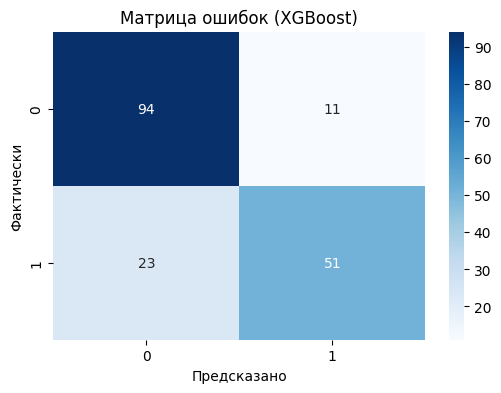

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:49:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:49:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:49:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:49:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:49:42] WARNING: /w


Модель: Ensemble
Лучшие параметры: N/A
Точность: 0.80
Кросс-валидация: 0.83 (+/- 0.04)
Отчет классификации:
              precision    recall  f1-score   support

           0       0.80      0.90      0.84       105
           1       0.82      0.68      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.80      0.80       179



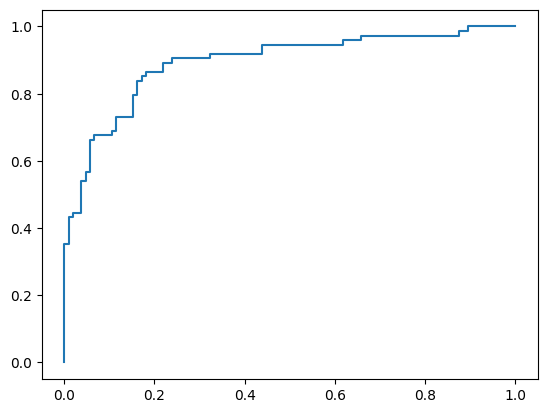

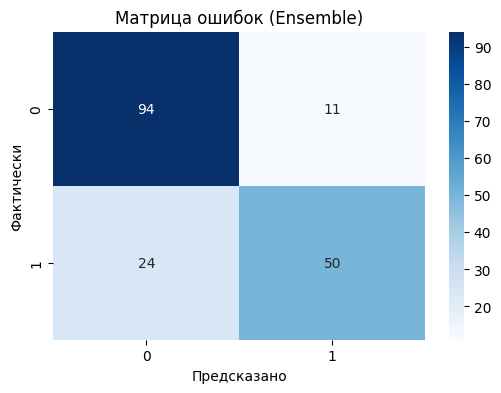

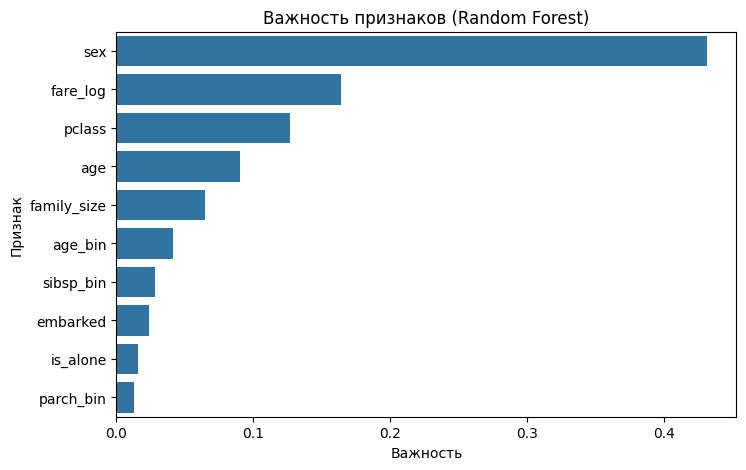

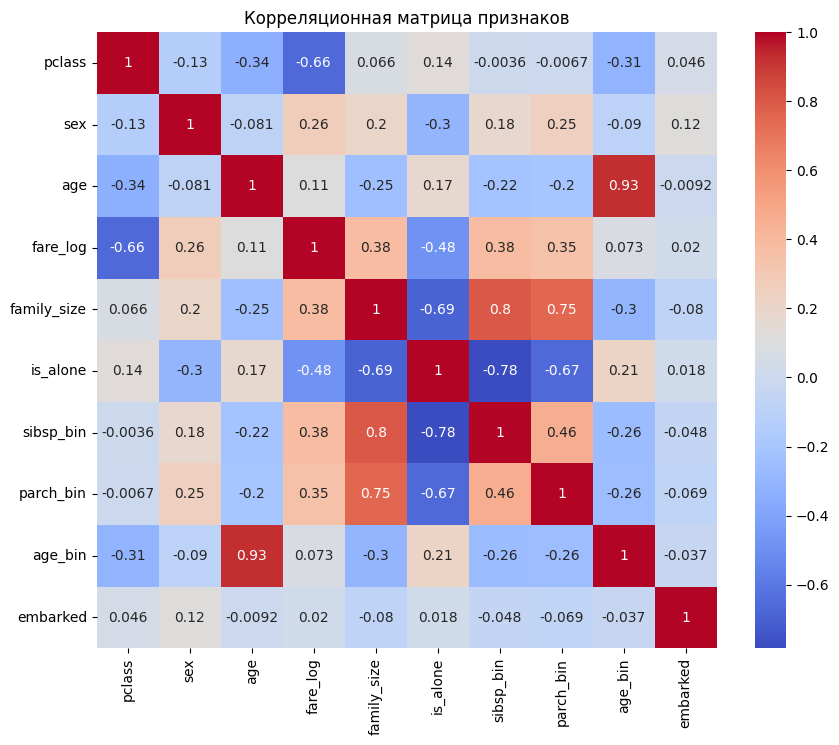

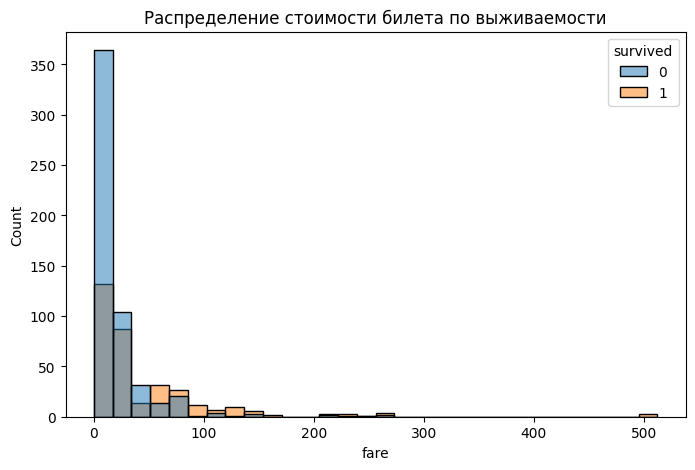

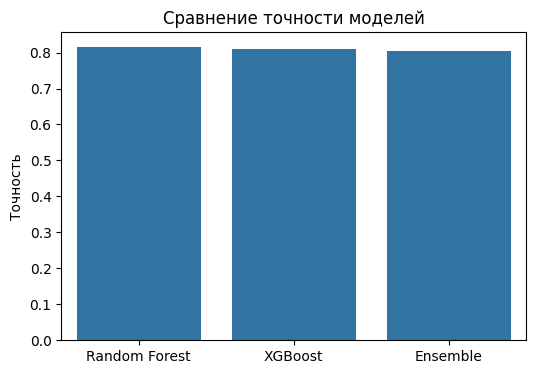

In [10]:

plt.figure(figsize=(10, 8))
for name, model in models.items():
    # Предсказания
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Точность и кросс-валидация
    accuracy = accuracy_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X, y, cv=5)
    results[name] = accuracy

    print(f'\nМодель: {name}')
    print(f'Лучшие параметры: {grid_rf.best_params_ if name == "Random Forest" else grid_xgb.best_params_ if name == "XGBoost" else "N/A"}')
    print(f'Точность: {accuracy:.2f}')
    print(f'Кросс-валидация: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')
    print('Отчет классификации:')
    print(classification_report(y_test, y_pred))

    # ROC-кривая
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Матрица ошибок ({name})')
    plt.xlabel('Предсказано')
    plt.ylabel('Фактически')
    plt.show()

feature_importance = pd.DataFrame({
    'Признак': features,
    'Важность': models['Random Forest'].feature_importances_
})
plt.figure(figsize=(8, 5))
sns.barplot(x='Важность', y='Признак', data=feature_importance.sort_values(by='Важность', ascending=False))
plt.title('Важность признаков (Random Forest)')
plt.show()

# Корреляционная матрица
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица признаков')
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(data=data, x='fare', hue='survived', bins=30)
plt.title('Распределение стоимости билета по выживаемости')
plt.show()

# Сравнение точности моделей
plt.figure(figsize=(6, 4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title('Сравнение точности моделей')
plt.ylabel('Точность')
plt.show()